#### Імпорт необхідних бібліотек (або окремих компонентів)

In [1]:
import json
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Callable
from datetime import datetime, timedelta, timezone
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.optimize import minimize, curve_fit

#### Функція для отримання даних з _CryptoCompare API_ про коливання курсу BTC/USD за вказний період з подальшим збереженням у форматі JSON

In [2]:
def fetch_btc_historical_data(symbol: str, end_date: str, limit: int = 364, currency: str = "USD") -> str:
    start_date = (datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=limit + 1)).strftime("%Y-%m-%d")
    end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    
    headers = {
        "Accepts": "application/json",
    }
    
    params = {
        "fsym": symbol,
        "tsym": currency,
        "limit": limit,
        "toTs": end_timestamp
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()

        extracted_data = []
        for entry in data["Data"]["Data"]:
            entry["date"] = datetime.fromtimestamp(entry["time"], tz=timezone.utc).strftime("%Y-%m-%d")
            del entry["time"]
            extracted_data.append(entry)

        file_name = f"{symbol}-{currency}_{start_date}_{end_date}.json"

        with open(file_name, "w") as file:
            json.dump(extracted_data, file, indent=4)

        print(f"Data saved successfully: \"{file_name}\"")
        return file_name
    else:
        raise Exception(f"Error {response.status_code}: {response.text}")

json_data = fetch_btc_historical_data("BTC", "2023-01-01")

Data saved successfully: "BTC-USD_2022-01-01_2023-01-01.json"


#### Формат вхідних даних (збережений JSON документ)

In [3]:
!head -n 23 *.json

[
    {
        "high": 47950.29,
        "low": 46196.03,
        "open": 46197.31,
        "volumefrom": 16697.92,
        "volumeto": 786729972.03,
        "close": 47737.35,
        "conversionType": "direct",
        "conversionSymbol": "",
        "date": "2022-01-01"
    },
    {
        "high": 47979.26,
        "low": 46666.18,
        "open": 47737.35,
        "volumefrom": 13025.66,
        "volumeto": 615453426.93,
        "close": 47306.41,
        "conversionType": "direct",
        "conversionSymbol": "",
        "date": "2022-01-02"
    },


#### Створення pandas DataFrame на основі збереженого JSON документу та вивід загальної інформації

In [4]:
cols = ["date", "open", "close", "high", "low"]

df = pd.read_json(json_data)[cols]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    365 non-null    float64
 1   close   365 non-null    float64
 2   high    365 non-null    float64
 3   low     365 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB


#### Вивід статистичних характеристик отриманих даних
- *count* - кількість спостережень (значень) у кожному стовпці
- *mean* - середнє арифметичне
- *std* - стандартне відхилення
- *min* та *max* - найменше та найбільше значення у вибірці
- *25%*, *50%*, *75%* - перший, другий (медіана) і третій квартилі

In [5]:
df.describe()

,open,close,high,low
count,365.000000,365.000000,365.000000,365.000000
mean,28267.278055,28186.001342,28875.363918,27540.394658
std,10222.664236,10197.618537,10461.473755,9949.503481
min,15760.190000,15760.190000,16272.470000,15480.690000
25%,19550.490000,19541.280000,20052.130000,19159.470000
50%,23179.860000,23156.660000,23595.740000,22668.870000
75%,39154.400000,39134.830000,39922.600000,38043.510000
max,47737.350000,47737.350000,48208.480000,47018.870000


#### Графік зміни курсу BTC/USD (денна ціна закриття) за 2022 рік

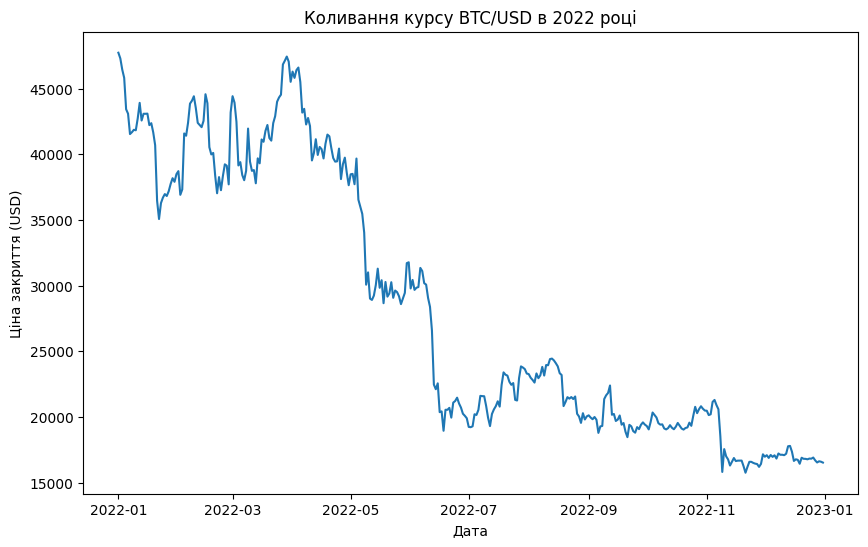

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df["close"])
plt.title("Коливання курсу BTC/USD в 2022 році")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.show()

#### Побудова поліноміальної регресійної моделі (ступінь полінома 3)

In [7]:
def fit_polynomial(y: np.ndarray, degree: int) -> np.poly1d:
    x = np.arange(len(y))
    coeffs = np.polyfit(x, y, deg=degree)
    print(f"Coefficients of the {degree}-degree polynomial: {coeffs}\n")
    return np.poly1d(coeffs)

degree = 3

polynomial_raw = fit_polynomial(df["close"].values, degree)
trend_raw = polynomial_raw(np.arange(len(df["close"])))

Coefficients of the 3-degree polynomial: [ 1.91321173e-03 -9.00183428e-01  1.09207985e+01  4.28787011e+04]



#### Обчислення R², MSE, RMSE, MAE метрик для оцінки якості моделі

In [8]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, model_name="Model") -> None:
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f" - R² Score: {r2:.4f}")
    print(f" - Mean Squared Error (MSE): {mse:.4f}")
    print(f" - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f" - Mean Absolute Error (MAE): {mae:.4f}\n")

evaluate_model(df["close"], trend_raw, model_name="Raw Data Polynomial")

Raw Data Polynomial Evaluation:
 - R² Score: 0.8861
 - Mean Squared Error (MSE): 11813711.3436
 - Root Mean Squared Error (RMSE): 3437.1080
 - Mean Absolute Error (MAE): 2639.2193



#### Графік реальних даних та тренду

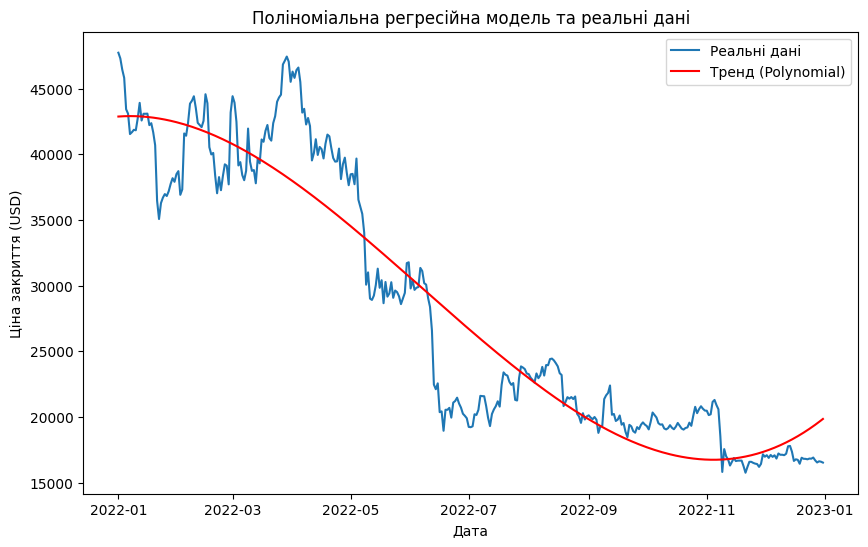

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["close"], label="Реальні дані")
plt.plot(df.index, trend_raw, label="Тренд (Polynomial)", color="red")
plt.title("Поліноміальна регресійна модель та реальні дані")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Розробка власного алгоритму виявлення аномалій
Розроблена функція `mad_based_anomaly_detection_dyn` використовується для виявлення аномалій у часових рядах на основі динамічного вікна та медіани абсолютних відхилень (MAD).

In [10]:
def mad_based_anomaly_detection_dyn(
    series: pd.Series,
    min_window: int,
    max_window: int,
    volatility_threshold: float,
    threshold: float,
    replacement_func: Callable[[pd.Series], float] = None,
) -> Tuple[pd.Series, List]:
    anomalies = []
    series_copy = series.copy()

    for idx in range(len(series)):
        local_data = series[max(0, idx - min_window):idx + 1]
        local_volatility = local_data.std()

        if np.isnan(local_volatility):
            local_volatility = 0

        window_size = int(
            min_window + (max_window - min_window) * (local_volatility / volatility_threshold)
        )
        window_size = min(max(window_size, min_window), max_window)

        start_idx = max(0, idx - window_size)
        end_idx = min(len(series), idx + window_size + 1)

        window_data = series.iloc[start_idx:end_idx].drop(series.index[idx])
        median = window_data.median()
        mad = np.median(np.abs(window_data - median))

        if mad == 0:
            mad = 1e-10  # Запобігання ділення на нуль

        deviation = np.abs(series.iloc[idx] - median) / mad

        if deviation > threshold:
            anomalies.append(series.index[idx])
            series_copy.iloc[idx] = replacement_func(window_data) if replacement_func else np.nan

    return series_copy, anomalies

# Застосування алгоритму для очищення даних

price_changes = df["close"].diff()
volatility_threshold = price_changes.std()
print(f"volatility_threshold: {volatility_threshold}")

df["close_cleaned"], anomalies = mad_based_anomaly_detection_dyn(
    series=df["close"],
    min_window=5,
    max_window=30,
    volatility_threshold=volatility_threshold,
    threshold=2.5,
    replacement_func=lambda window_data: window_data.median(),
)

print(f"anomalies detected: {len(anomalies)}")

volatility_threshold: 1015.3050444402861
anomalies detected: 33


#### Графік реальних, очищених даних та виявлених аномалій

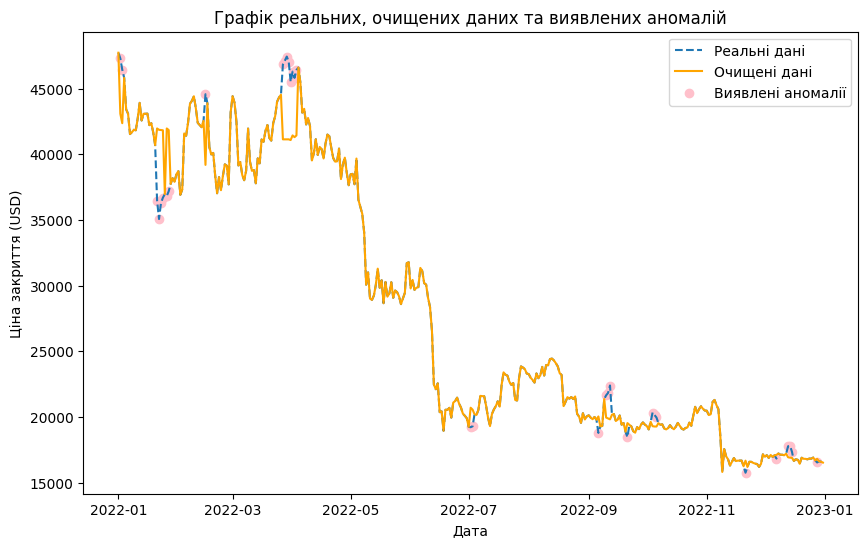

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["close"], label="Реальні дані", linestyle="--")
plt.plot(df.index, df["close_cleaned"], label="Очищені дані", color="orange")
plt.scatter(anomalies, df.loc[anomalies, "close"], color="pink", label="Виявлені аномалії",)
plt.title("Графік реальних, очищених даних та виявлених аномалій")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Побудова поліноміальної регресійної моделі на очищених даних та її оцінка

In [12]:
polynomial_cleaned = fit_polynomial(df["close_cleaned"].values, degree)
trend_cleaned = polynomial_cleaned(np.arange(len(df["close_cleaned"])))

evaluate_model(df["close_cleaned"], trend_cleaned, model_name="Cleaned Data Polynomial")

Coefficients of the 3-degree polynomial: [ 1.75089668e-03 -8.02394408e-01 -5.21425419e+00  4.33760691e+04]

Cleaned Data Polynomial Evaluation:
 - R² Score: 0.9060
 - Mean Squared Error (MSE): 9497640.9507
 - Root Mean Squared Error (RMSE): 3081.8243
 - Mean Absolute Error (MAE): 2375.2084



#### Графік очищених даних та тренду

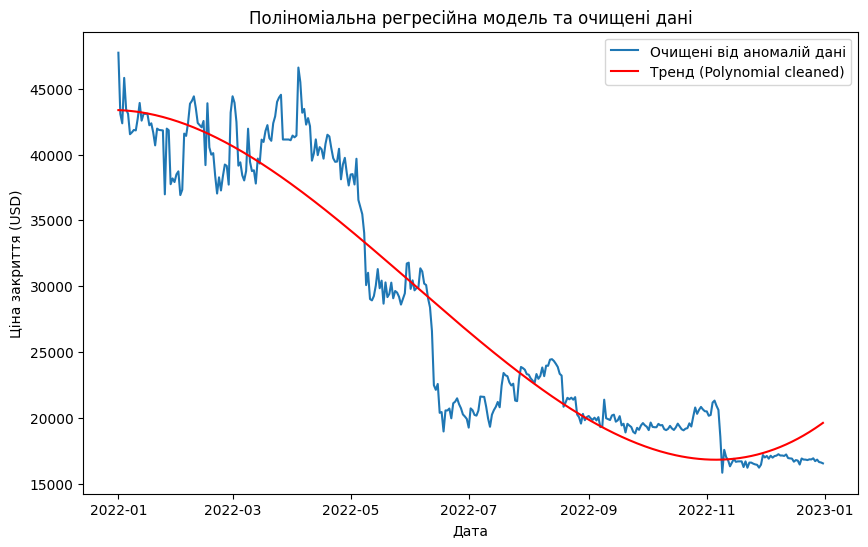

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["close_cleaned"], label="Очищені від аномалій дані")
plt.plot(df.index, trend_cleaned, label="Тренд (Polynomial cleaned)", color="red")
plt.title("Поліноміальна регресійна модель та очищені дані")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Спроба покращити модель, використовуючи поліноміально-експоненційну функцію

In [14]:
def polynomial_exponential(x: np.ndarray, a0: float, a1: float, a2: float, a3: float, a4: float) -> float:
    return a0 + a1 * x + a2 * x**2 + a3 * np.exp(a4 * x)

def fit_polynomial_exponential(x_data: np.ndarray, y_data: np.ndarray, initial_coeffs: List[float]) -> np.ndarray:
    optimal_params, _ = curve_fit(polynomial_exponential, x_data, y_data, p0=initial_coeffs)
    print(f"Optimal coefficients: {optimal_params}\n")
    return optimal_params

initial_coeffs = [45000, -1000, 10, -5000, -0.07] # аналітично підібрані початкові значення коефіцієнтів
x_data, y_data = np.arange(len(df["close_cleaned"])), df["close_cleaned"].values

optimal_coeffs = fit_polynomial_exponential(x_data, y_data, initial_coeffs)
trend_optimized = polynomial_exponential(x_data, *optimal_coeffs)

evaluate_model(df["close_cleaned"], trend_optimized, model_name="Polynomial-Exponential Model")

Optimal coefficients: [ 7.11420129e+04 -3.40473643e+02  5.39675101e-01 -3.09584036e+04
 -1.73072341e-02]

Polynomial-Exponential Model Evaluation:
 - R² Score: 0.9166
 - Mean Squared Error (MSE): 8426668.7998
 - Root Mean Squared Error (RMSE): 2902.8725
 - Mean Absolute Error (MAE): 2256.5756



#### Графік очищених даних та поліноміально-експоненційної моделі

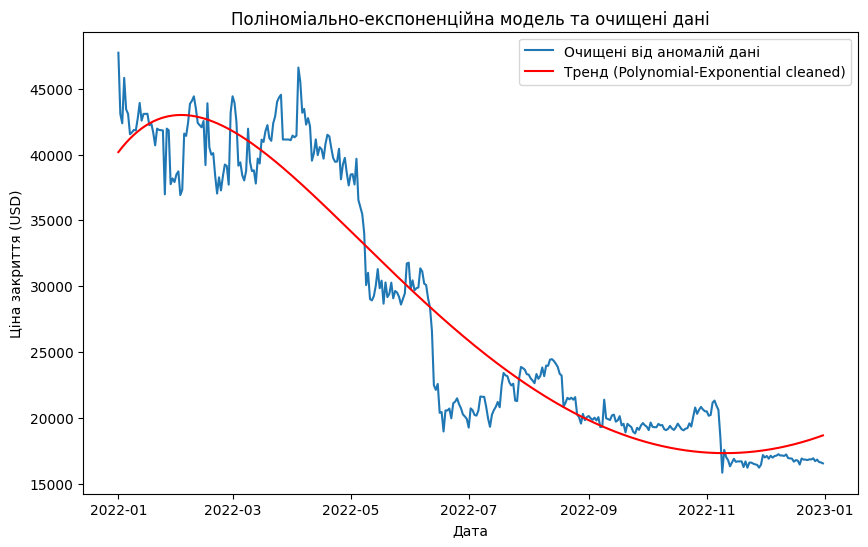

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df["close_cleaned"], label="Очищені від аномалій дані")
plt.plot(df.index, trend_optimized, label="Тренд (Polynomial-Exponential cleaned)", color='red')
plt.title("Поліноміально-експоненційна модель та очищені дані")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Рекурентне згладжування даних за допомогою Alpha-Beta-Gamma фільтра

In [16]:
def alpha_beta_gamma_filter(
    measurements: np.ndarray,
    alpha: float,
    beta: float,
    gamma: float,
    delta_t: int = 1
) -> np.ndarray:
    n = len(measurements)
    x_filtered = np.zeros(n)
    
    x_est, v_est, a_est = measurements[0], 0.0, 0.0
    x_filtered[0] = x_est

    for k in range(1, n):
        dt = delta_t

        x_pred = x_est + v_est * dt + 0.5 * a_est * dt**2
        v_pred = v_est + a_est * dt
        a_pred = a_est

        r = measurements[k] - x_pred

        x_est = x_pred + alpha * r
        v_est = v_pred + beta * r / dt
        a_est = a_pred + gamma * r / (0.5 * dt**2)

        x_filtered[k] = x_est

    return x_filtered

# Оптимізація параметрів Alpha-Beta-Gamma фільтра

def objective_function(
    params: Tuple[float, float, float],
    measurements: np.ndarray,
    lambda_smooth: float = 0.5
) -> float:
    alpha, beta, gamma = params

    if not (0 < alpha < 1 and 0 < beta < 1 and 0 < gamma < 1):
        return np.inf
    
    filtered_measurements = alpha_beta_gamma_filter(measurements, alpha, beta, gamma)
    
    mse = mean_squared_error(measurements, filtered_measurements)    # MSE між початковими та відфільтрованими даними
    smoothness_penalty = np.sum(np.diff(filtered_measurements)**2)   # Штраф за незгладженість (сума квадратів різниць відфільтрованих даних)
    total_cost = mse + lambda_smooth * smoothness_penalty            # Оцінка параметрів = MSE + штраф за незгладженість * коефіцієнт ваги

    return total_cost

measurements = df["close_cleaned"].values
initial_params = (0.5, 0.15, 0.01)
bounds = [(0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999)]

result = minimize(
    objective_function,
    initial_params,
    args=(measurements,),
    method="L-BFGS-B",
    bounds=bounds,
    options={"disp": True},
)

alpha_opt, beta_opt, gamma_opt = result.x
print(f"Optimized parameters:\nAlpha: {alpha_opt}\nBeta: {beta_opt}\nGamma: {gamma_opt}\n")

df["close_filtered"] = alpha_beta_gamma_filter(measurements, alpha_opt, beta_opt, gamma_opt)

evaluate_model(measurements, df["close_filtered"], model_name="Alpha-Beta-Gamma Filter")

Optimized parameters:
Alpha: 0.10093155411805324
Beta: 0.006691364445962987
Gamma: 0.0001

Alpha-Beta-Gamma Filter Evaluation:
 - R² Score: 0.9585
 - Mean Squared Error (MSE): 4191280.0611
 - Root Mean Squared Error (RMSE): 2047.2616
 - Mean Absolute Error (MAE): 1611.4889

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43436D+07    |proj g|=  4.99900D-01

At iterate    1    f=  6.64731D+07    |proj g|=  7.49850D-01

At iterate    2    f=  3.10849D+07    |proj g|=  9.36300D-01
  ys=-1.820E+08  -gs= 4.588E+06 BFGS update SKIPPED

At iterate    3    f=  3.08705D+07    |proj g|=  9.28950D-01

At iterate    4    f=  3.08136D+07    |proj g|=  9.30276D-01

At iterate    5    f=  3.07069D+07    |proj g|=  9.33105D-01

At iterate    6    f=  3.01604D+07    |proj g|=  9.33980D-01

At iterate    7    f=  2.61795D+07    |proj g|=  9.28638D-01

At iterat

#### Графік очищених та згладжених даних

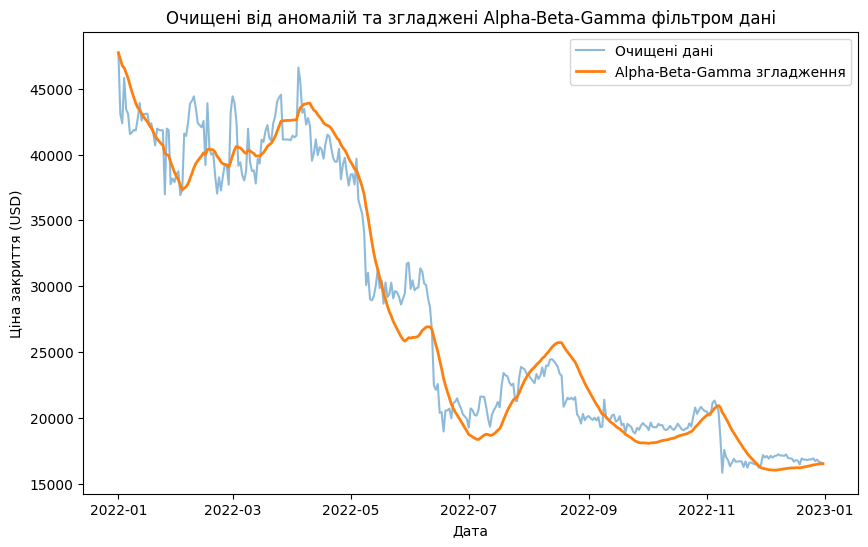

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["close_cleaned"], label="Очищені дані", alpha=0.5)
plt.plot(df.index, df["close_filtered"], label="Alpha-Beta-Gamma згладження", linewidth=2)
plt.title("Очищені від аномалій та згладжені Alpha-Beta-Gamma фільтром дані")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()